In [1]:
# Load the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import display
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import statsmodels.api as sm
from datetime_truncate import truncate

### Step 1: Load the dataset

In [2]:
file_path = "J:\\My Drive\\AUC Drive\\1_Work and School Data Migration\\W Laptop Backup_20210629\\Personal Folders on the Desktop Combined_Uploaded\\Applications and Work-related Items\\About You\\data.parquet"
df = pd.read_parquet(file_path)
df # Display the dataset

,product_id,brand_name,category_name,product_group_name,product_group_gender,style_group,season,items_sold,price_before_discount,price_after_disocunt,items_left_in_sttock,active_since_days,dayofyear,normalized_number_of_visitors,discount,is_sale_campaign_day,is_holiday
0,97,POPULAR BRAND,Pleat-front trousers,Trousers,female,Fast Trend Women,FS,4,33.53,26.82,290,1389,1,-0.434670,0.2,1.0,1.0
1,97,POPULAR BRAND,Pleat-front trousers,Trousers,female,Fast Trend Women,FS,2,33.53,26.82,283,1390,2,-0.188708,0.2,1.0,0.0
2,97,POPULAR BRAND,Pleat-front trousers,Trousers,female,Fast Trend Women,FS,9,33.53,26.82,274,1391,3,-0.023852,0.2,1.0,1.0
3,97,POPULAR BRAND,Pleat-front trousers,Trousers,female,Fast Trend Women,FS,2,33.53,33.53,260,1392,4,-0.444416,0.0,0.0,0.0
4,97,POPULAR BRAND,Pleat-front trousers,Trousers,female,Fast Trend Women,FS,1,33.53,33.53,249,1393,5,-0.418527,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324605,8254,POPULAR BRAND,Jeans,Jeans,female,Kids,FS,1,33.61,33.61,764,344,362,-0.041448,0.0,0.0,0.0
324606,8254,POPULAR BRAND,Jeans,Jeans,female,Kids,FS,1,33.61,33.61,771,345,363,0.471975,0.0,1.0,0.0
324607,8254,POPULAR BRAND,Jeans,Jeans,female,Kids,FS,0,33.61,33.61,773,346,364,0.293996,0.0,1.0,0.0
324608,8254,POPULAR BRAND,Jeans,Jeans,female,Kids,FS,3,33.61,33.61,779,347,365,-0.306065,0.0,1.0,0.0


### Step 2: Export the data to an Excel file so that we can load it to Tableau (another alternative is to convert the .parquet file to a .hyper file)

In [17]:
df.to_excel('data.xlsx', sheet_name = 'Sheet1', index = False)

### Step 3: Amend the formatting of the data by correcting typos column names and assigning the right data type to each column

In [3]:
# Correct the typo in the column name "items_left_in_sttock"
df.rename(columns = {'items_left_in_sttock': 'items_left_in_stock', 'price_after_disocunt': 'price_after_discount'}, inplace = True)

# Display the data types of the imported dataset
display(df.dtypes)

# Print a separator
print('\n##-----------------------##\n')

# Change the column types
integer_cols = ['product_id', 'items_sold', 'items_left_in_stock', 'active_since_days', 'dayofyear']
float_cols = ['price_before_discount', 'price_after_discount', 'normalized_number_of_visitors', 'discount']
str_cols = ['brand_name', 'category_name', 'product_group_name', 'product_group_gender', 'style_group', 'season']
bool_cols = ['is_sale_campaign_day', 'is_holiday']

def change_dtype_func(data, cols, new_dtype):
    data[cols] = data[cols].astype(new_dtype)

change_dtype_func(df, integer_cols, int)
change_dtype_func(df, float_cols, float)
change_dtype_func(df, str_cols, str)
change_dtype_func(df, bool_cols, bool)

# Display the data types after the amendments
display(df.dtypes)

product_id                         int64
brand_name                        object
category_name                     object
product_group_name                object
product_group_gender              object
style_group                       object
season                            object
items_sold                         int64
price_before_discount            float64
price_after_discount             float64
items_left_in_stock                int64
active_since_days                  int64
dayofyear                         object
normalized_number_of_visitors    float64
discount                         float64
is_sale_campaign_day             float64
is_holiday                       float64
dtype: object


##-----------------------##



product_id                         int32
brand_name                        object
category_name                     object
product_group_name                object
product_group_gender              object
style_group                       object
season                            object
items_sold                         int32
price_before_discount            float64
price_after_discount             float64
items_left_in_stock                int32
active_since_days                  int32
dayofyear                          int32
normalized_number_of_visitors    float64
discount                         float64
is_sale_campaign_day                bool
is_holiday                          bool
dtype: object

### Step 4: Change the "dayofyear" value of the 366th record belonging to each product ID from "1" to "366" so that it is not confused with the first day of the year

In [4]:
# Get the last "active_since_days" value for each product ID
df_max_active_since_days = df.groupby(df['product_id'])['product_id', 'active_since_days'].max().reset_index(drop = True)\
    .rename(columns = {'active_since_days': 'max_active_since_days'})

# LEFT JOIN the dataset above to "df"
df = df.merge(df_max_active_since_days, how = 'left', on = 'product_id')

# Overwrite the "dayofyear" value to "366" for each product_id where active_since_days = max_active_since_days
df.loc[df['active_since_days'] == df['max_active_since_days'], 'dayofyear'] = 366

C:\Users\Temporary Admin\AppData\Local\Temp\ipykernel_10792\3230159444.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_max_active_since_days = df.groupby(df['product_id'])['product_id', 'active_since_days'].max().reset_index(drop = True)\


### Step 5: Add calculated fields to the dataset 

In [5]:
# Add a column for the gmv generated from the items sold
df = df.assign(gmv = lambda x: x['items_sold'] * x['price_after_discount'])

# Display the first 5 rows of the dataset to see the calculation(s)
df.head(5)

,product_id,brand_name,category_name,product_group_name,product_group_gender,style_group,season,items_sold,price_before_discount,price_after_discount,items_left_in_stock,active_since_days,dayofyear,normalized_number_of_visitors,discount,is_sale_campaign_day,is_holiday,max_active_since_days,gmv
0,97,POPULAR BRAND,Pleat-front trousers,Trousers,female,Fast Trend Women,FS,4,33.53,26.82,290,1389,1,-0.434670,0.2,True,True,1754,107.28
1,97,POPULAR BRAND,Pleat-front trousers,Trousers,female,Fast Trend Women,FS,2,33.53,26.82,283,1390,2,-0.188708,0.2,True,False,1754,53.64
2,97,POPULAR BRAND,Pleat-front trousers,Trousers,female,Fast Trend Women,FS,9,33.53,26.82,274,1391,3,-0.023852,0.2,True,True,1754,241.38
3,97,POPULAR BRAND,Pleat-front trousers,Trousers,female,Fast Trend Women,FS,2,33.53,33.53,260,1392,4,-0.444416,0.0,False,False,1754,67.06
4,97,POPULAR BRAND,Pleat-front trousers,Trousers,female,Fast Trend Women,FS,1,33.53,33.53,249,1393,5,-0.418527,0.0,False,False,1754,33.53


### Step 6: Do some exploratory data analysis to obtain general statistics about the sales

In [6]:
# Step 6.1: Number of products in the dataset
print('Statement 1: The number of unique products in the dataset is: {}'.format(df['product_id'].nunique()))

# Step 6.2: Number of categories
print('Statement 2: There are {num_pgs} product groups and {num_cat} categories in the dataset. In total, there are {num_combos} unique combinations of both' \
    .format(
        num_pgs = df['product_group_name'].nunique(), 
        num_cat = df['category_name'].nunique(), 
        num_combos = len(df.groupby(['product_group_name', 'category_name']).size())
    )
)

# Step 6.3: Total orders and gmv generated in the entire year
print('Statement 3: The total units sold in the entire year amounted to {:,.0f} and the GMV generated from those orders amounted to {:,.2f} EUR' \
    .format(df['items_sold'].sum(), df['gmv'].sum())
)

# Step 6.4: Calculate the GMV-weighted average price point after discount, AOV, and GMV-weighted average discount
print('Statement 4: The GMV-weighted average price point after discount is {avg_pp} EUR. The AOV is {aov} EUR. The GMV-weighted average discount is {avg_disc}%'\
    .format(
        avg_pp = round(((df['price_after_discount'] * df['gmv']).sum()) / df['gmv'].sum(), 2),
        aov = round(df['gmv'].sum() / df['items_sold'].sum(), 2),
        avg_disc = round(((df['discount'] * df['gmv']).sum()) / df['gmv'].sum(), 4) * 100,
    )
)

# Step 6.5: Find the number of days where there was a holiday or there was a campaign for at least one product
print('Statement 6: Out of the 366 days, there were {} days where there was a holiday and {} days where there was a sale campaign for at least one product' \
    .format(
        df.loc[df['is_holiday'] == True, 'dayofyear'].nunique(),
        df.loc[df['is_sale_campaign_day'] == True, 'dayofyear'].nunique()
    ))

# Step 6.6: Find the oldest and newest products in the dataset based on the "active_since_days" column
print('Statement 7: At the start of the year, the oldest product in the dataset had stayed active for {} days or {} years. {} products are in their first week of being introduced to the catalog' \
    .format(
        df[df['dayofyear'] == df['dayofyear'].min()]['active_since_days'].max(),
        round(df[df['dayofyear'] == df['dayofyear'].min()]['active_since_days'].max() / 365, 2),
        df[(df['active_since_days'] <= 7) & (df['dayofyear'] == 1)]['product_id'].nunique(), # df['dayofyear'] == 1 is the same as df['dayofyear'] == df['dayofyear'].min()
    )
)

# Step 6.6.1: Show the oldest product in the catalog
max_active_since_days_val = df[df['dayofyear'] == df['dayofyear'].min()]['active_since_days'].max()
display(df[(df['active_since_days'] == max_active_since_days_val) & (df['dayofyear'] == 1)].drop(['brand_name', 'product_group_gender'], axis = 1))

# Step 6.6.2: Show the 3 products that had less than 7 days of display life at the beginning of the year
display(df[(df['active_since_days'] <= 7) & (df['dayofyear'] == 1)].drop(['brand_name', 'product_group_gender'], axis = 1))

Statement 1: The number of unique products in the dataset is: 1000
Statement 2: There are 16 product groups and 37 categories in the dataset. In total, there are 37 unique combinations of both
Statement 3: The total units sold in the entire year amounted to 3,795,729 and the GMV generated from those orders amounted to 91,536,079.26 EUR
Statement 4: The GMV-weighted average price point after discount is 27.08 EUR. The AOV is 24.12 EUR. The GMV-weighted average discount is 5.86%
Statement 6: Out of the 366 days, there were 63 days where there was a holiday and 156 days where there was a sale campaign for at least one product
Statement 7: At the start of the year, the oldest product in the dataset had stayed active for 2532 days or 6.94 years. 3 products are in their first week of being introduced to the catalog


,product_id,category_name,product_group_name,style_group,season,items_sold,price_before_discount,price_after_discount,items_left_in_stock,active_since_days,dayofyear,normalized_number_of_visitors,discount,is_sale_campaign_day,is_holiday,max_active_since_days,gmv
269989,1,Top,Shirts & Tops,Fast Trend Women,FS,106,8.32,7.07,1761,2532,1,-0.43467,0.15,True,True,2897,749.42


,product_id,category_name,product_group_name,style_group,season,items_sold,price_before_discount,price_after_discount,items_left_in_stock,active_since_days,dayofyear,normalized_number_of_visitors,discount,is_sale_campaign_day,is_holiday,max_active_since_days,gmv
14229,8173,Sweater,Sweaters & Cardigans,Fast Trend Women,FS,10,18.40,18.40,789,1,1,-0.43467,0.0,True,True,366,184.0
275412,7918,Jeans,Jeans,Fast Trend Women,FS,0,33.61,33.61,404,4,1,-0.43467,0.0,True,True,369,0.0
278527,8047,Sweater,Sweaters & Cardigans,Fast Trend Women,FS,0,25.13,25.13,775,3,1,-0.43467,0.0,True,True,368,0.0


In [7]:
# Step 6.7: Display the number of products per product group | category combination

# Create a data frame where the total number of products per "product_group" | "category_name" combination is computed
df_prod_count_cat = df.groupby(['product_group_name', 'category_name']) \
    .agg(
        product_count = ('product_id', lambda x: x.nunique()),
        sales = ('gmv', np.sum)
    ).reset_index()

# Create another data frame where the total number of products AND total amount of sales per product group is calculated and rename the "product_id" column to "product_count"
df_prod_count_group = df_prod_count_cat.groupby('product_group_name') \
    .agg(
        product_group_tot_product_count = ('product_count', np.sum),
        product_group_tot_sales = ('sales', np.sum)
    )

# Add another column to "df_prod_count_cat" to calculate the share of products AND share of sales attributed to each "product_group_name" | "category_name" combination
df_prod_count_cat['product_share'] = round(df_prod_count_cat['product_count'] / df_prod_count_cat['product_count'].sum(), 4)
df_prod_count_cat['sales_share'] = round(df_prod_count_cat['sales'] / df_prod_count_cat['sales'].sum(), 4)

# Combine both data frames and create a new pivot table
df_prod_count_combos = df_prod_count_cat \
                    .merge(df_prod_count_group, how = 'left', on = 'product_group_name') \
                    .pivot_table(
                        index = ['product_group_name', 'category_name'],
                        values = ['product_group_tot_product_count', 'product_group_tot_sales', 'product_count', 'product_share', 'sales', 'sales_share']
                    ) \
                    .sort_values(by = 'product_group_tot_sales', ascending = False)

# Display the top 5 product groups
top5_prod_groups = df_prod_count_combos.index.get_level_values('product_group_name').unique()[0:5]
df_prod_count_combos_top5 = df_prod_count_combos.loc[top5_prod_groups, ['product_group_tot_product_count', 'product_group_tot_sales', 'product_count', 'product_share', 'sales', 'sales_share']]

# Add a thousands separator to 'sales' and 'product_group_tot_sales'
def add_thousands_sep_func(df, col):
    df[col] = df[col].apply('{:,.2f}'.format)

# The function above changes the data type of these two columns to "object"
# So, we store the "df_prod_count_combos_top5" data frame in a temp table just to display it wout affecting the data types
temp = df_prod_count_combos_top5.copy() 
add_thousands_sep_func(temp, 'sales')
add_thousands_sep_func(temp, 'product_group_tot_sales')
display(temp)

# Print a statement describing the dataset
print('The top 5 product groups constitute {top_5_sales_share}% of total sales and have {top_5_prod_share}% of all products in the catalog' \
    .format(
        top_5_sales_share = round(df_prod_count_combos_top5['sales_share'].sum() * 100, 2), 
        top_5_prod_share = round(df_prod_count_combos_top5['product_share'].sum() * 100, 2)
    )
)

product_group_tot_product_count  \
product_group_name   category_name                                           
Jeans                Jeans                                             217   
                     Cargo jeans                                       217   
                     Jeggings                                          217   
Shirts & Tops        Top                                               216   
                     Shirt                                             216   
                     Oversized shirt                                   216   
                     Knitted top                                       216   
Sweaters & Cardigans Sweater                                           151   
                     Oversized sweater                                 151   
                     Knit cardigan                                     151   
Trousers             Cargo trousers                                     84   
                     Pleat-front trousers                               84   
                     Trousers                                           84   
                     Leggings                                           84   
                     Chino trousers                                     84   
Dresses              Cocktail dress                                    137   
                     Summer dress                                      137   
                     Shirt dress                                       137   
                     Knit dress                                        137   
                     Dress                                             137   

                                          product_group_tot_sales  \
product_group_name   category_name                                  
Jeans                Jeans                          38,741,736.17   
                     Cargo jeans                    38,741,736.17   
                     Jeggings                       38,741,736.17   
Shirts & Tops        Top                            10,051,960.14   
                     Shirt                          10,051,960.14   
                     Oversized shirt                10,051,960.14   
                     Knitted top                    10,051,960.14   
Sweaters & Cardigans Sweater                         9,760,876.64   
                     Oversized sweater               9,760,876.64   
                     Knit cardigan                   9,760,876.64   
Trousers             Cargo trousers                  9,746,388.54   
                     Pleat-front trousers            9,746,388.54   
                     Trousers                        9,746,388.54   
                     Leggings                        9,746,388.54   
                     Chino trousers                  9,746,388.54   
Dresses              Cocktail dress                  8,959,595.73   
                     Summer dress                    8,959,595.73   
                     Shirt dress                     8,959,595.73   
                     Knit dress                      8,959,595.73   
                     Dress                           8,959,595.73   

                                           product_count  product_share  \
product_group_name   category_name                                        
Jeans                Jeans                           210          0.210   
                     Cargo jeans                       2          0.002   
                     Jeggings                          5          0.005   
Shirts & Tops        Top                              76          0.076   
                     Shirt                           137          0.137   
                     Oversized shirt                   1          0.001   
                     Knitted top                       2          0.002   
Sweaters & Cardigans Sweater                          94          0.094   
                     Oversized sweater                 4 

The top 5 product groups constitute 84.41% of total sales and have 80.5% of all products in the catalog


C:\Users\Temporary Admin\AppData\Local\Temp\ipykernel_10792\2356256698.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot2.set_yticklabels(ylabels)


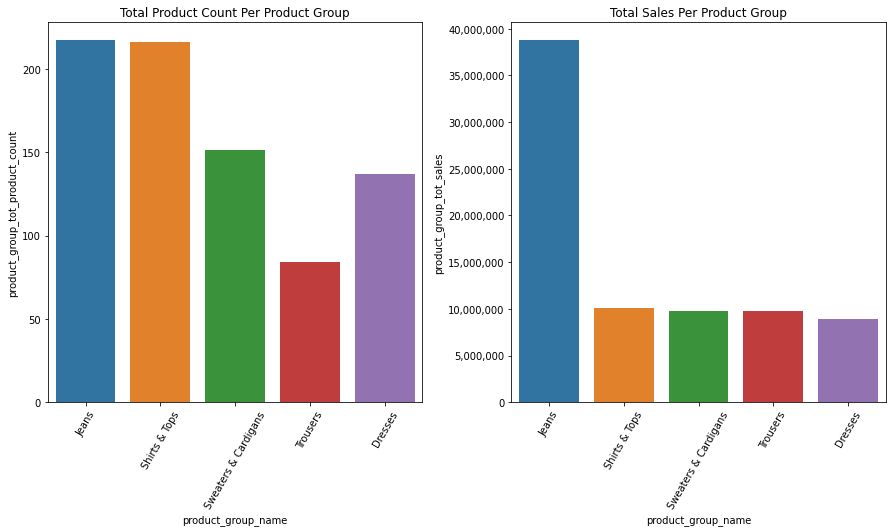

In [8]:
# Step 6.8: Plot a matrix plot showing the distribution of sales across the different categories

# Create a dataset
df_prod_count_combos_top5_flat = df_prod_count_combos_top5.reset_index()

# Create a canvas and specify the figure size
plt.figure(figsize = (12.5,7.5))

# Plot the product_group_name against the total product count per product group
plt.subplot(1,2,1)
sns.barplot(x = 'product_group_name', y = 'product_group_tot_product_count', data = df_prod_count_combos_top5_flat)
plt.title('Total Product Count Per Product Group')
# Rotate axes
plt.xticks(rotation = 60)

# Plot the product_group_name against the total sales per product group
plt.subplot(1,2,2)
plot2 = sns.barplot(x = 'product_group_name', y = 'product_group_tot_sales', data = df_prod_count_combos_top5_flat)
ylabels = ['{:,.0f}'.format(x) for x in plot2.get_yticks()]
plot2.set_yticklabels(ylabels)
plt.title('Total Sales Per Product Group')
# Rotate axes
plt.xticks(rotation = 60)

# Ensure that there is no overlapping
plt.tight_layout()


### Step 7: Compare the top five product groups in terms of price points, sales trends and traffic levels

Text(0.5, 1.0, 'Box Plots Comparing the Top Five Product Groups in Terms of Price Point')

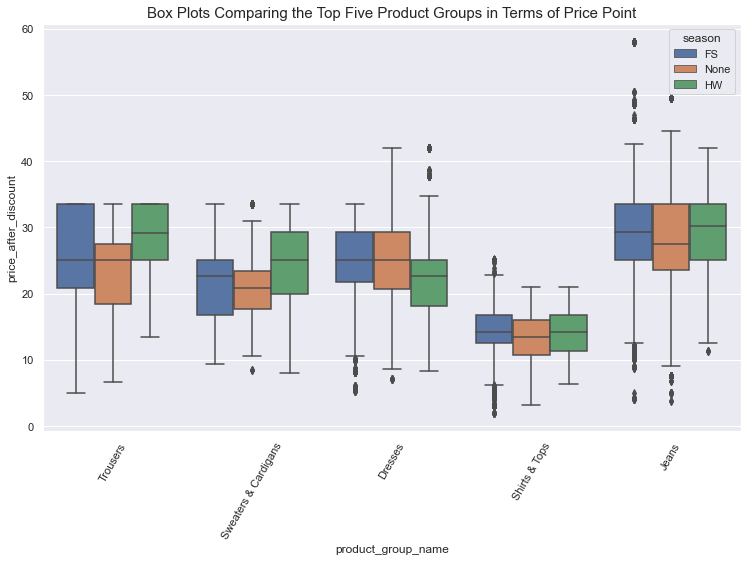

In [9]:
# Step 7.1: Draw box plots showing the distribution of price point per product group | season combination
sns.set(rc = {'figure.figsize': (12.5,7.5)})
sns.boxplot(x = 'product_group_name', y = 'price_after_discount', hue = 'season', data = df[df['product_group_name'].isin(top5_prod_groups)])
# Rotate axes
plt.xticks(rotation = 60)
# Add title
plt.title('Box Plots Comparing the Top Five Product Groups in Terms of Price Point', fontdict = {'size': 15})


,date,product_group_name,items_sold,items_left_in_stock,gmv,7D_MA_items_sold,7D_MA_items_left_in_stock,7D_MA_gmv
0,2021-01-01,Dresses,192,7415,3760.70,NaN,NaN,NaN
1,2021-01-01,Jeans,3545,157801,90348.95,NaN,NaN,NaN
2,2021-01-01,Shirts & Tops,1540,80782,18266.39,NaN,NaN,NaN
3,2021-01-01,Sweaters & Cardigans,1477,77465,28468.13,NaN,NaN,NaN
4,2021-01-01,Trousers,733,39019,20175.70,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1825,2022-01-01,Dresses,165,23298,3458.32,236.142857,24097.428571,5484.170000
1826,2022-01-01,Jeans,1981,323522,57884.04,1815.571429,325018.571429,53141.988571
1827,2022-01-01,Shirts & Tops,750,100048,10663.19,599.428571,99935.714286,8605.785714
1828,2022-01-01,Sweaters & Cardigans,889,107545,20102.96,931.142857,107038.857143,21455.834286


Text(0.5, 1.0, 'Daily Time Series Plot of Inventory Levels for Each Product Group')

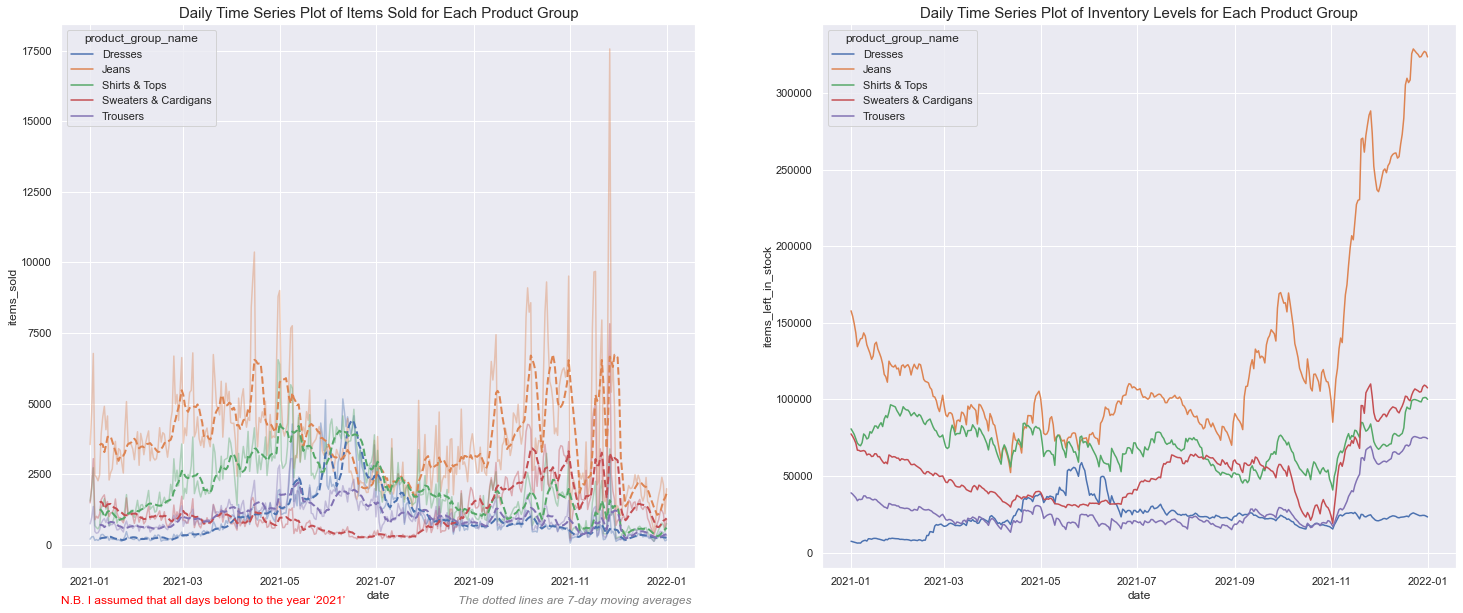

In [10]:
# Step 7.2: Plot the sales and inventory trends per product group throughout the year

# First, create a subset of the "df" dataframe containing the information we need about the top 5 product groups
df_sales_and_inventory_top5 = df.loc[df['product_group_name'] \
    .isin(top5_prod_groups), ['product_id', 'product_group_name', 'dayofyear', 'items_sold', 'gmv', 'items_left_in_stock', 'price_after_discount', 'discount']
]

# Second, change the 'dayofyear' into a datetime column so that we can plot timeseries graphs. Assume that the year in question is 2021
df_sales_and_inventory_top5['year'] = 2021
df_sales_and_inventory_top5['combined'] = df_sales_and_inventory_top5['year']*1000 + df_sales_and_inventory_top5['dayofyear']
df_sales_and_inventory_top5['date'] = pd.to_datetime(df_sales_and_inventory_top5['combined'], format = '%Y%j')
df_sales_and_inventory_top5['month_str'] = df_sales_and_inventory_top5['date'].dt.strftime('%b')
df_sales_and_inventory_top5['month_num'] = df_sales_and_inventory_top5['date'].dt.month

# Third, sum the items_sold, gmv, and items_left_in_stock per date | product_group_name combination
df_sales_and_inventory_top5_agg_day = df_sales_and_inventory_top5.groupby(['date', 'product_group_name'], as_index = False)[['items_sold', 'items_left_in_stock', 'gmv']].sum()

# Fourth, add 7-day moving average calculations to smoothen the volatility of the line charts
df_sales_and_inventory_top5_agg_day['7D_MA_items_sold'] = df_sales_and_inventory_top5_agg_day \
    .groupby('product_group_name')['items_sold'] \
    .transform(lambda x: x.rolling(7, min_periods = 7).mean())

df_sales_and_inventory_top5_agg_day['7D_MA_items_left_in_stock'] = df_sales_and_inventory_top5_agg_day \
    .groupby('product_group_name')['items_left_in_stock'] \
    .transform(lambda x: x.rolling(7, min_periods = 7).mean())

df_sales_and_inventory_top5_agg_day['7D_MA_gmv'] = df_sales_and_inventory_top5_agg_day \
    .groupby('product_group_name')['gmv'] \
    .transform(lambda x: x.rolling(7, min_periods = 7).mean())

# df_sales_and_inventory_top5_agg_day.set_index('date', inplace = True) # Set the date column as the index
display(df_sales_and_inventory_top5_agg_day)

# Now, plot the time series of sales and inventory trends
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (25,10))

sns.lineplot(ax = axes[0], x = 'date', y = 'items_sold', data = df_sales_and_inventory_top5_agg_day, hue = 'product_group_name', alpha = 0.4) # Original daily data
sns.lineplot(
    ax = axes[0], x = 'date', y = '7D_MA_items_sold', data = df_sales_and_inventory_top5_agg_day, 
    hue = 'product_group_name', lw = 2, ls = '--', legend = False
) # Superimpose the 7-day MA line
fig.text(0.125, 0.075, 'N.B. I assumed that all days belong to the year ‘2021’', ha = 'left', fontdict={'color': 'red'})
fig.text(0.475, 0.075, 'The dotted lines are 7-day moving averages', ha = 'right', fontdict={'color': 'gray', 'style': 'italic'})

sns.lineplot(ax = axes[1], x = 'date', y = 'items_left_in_stock', data = df_sales_and_inventory_top5_agg_day, hue = 'product_group_name') # Original daily data of items_left_in_stock
# sns.lineplot(ax = axes[2], x = 'date', y = 'gmv', data = df_sales_and_inventory_top5_agg_day, hue = 'product_group_name')

# Set the titles
axes[0].set_title('Daily Time Series Plot of Items Sold for Each Product Group', size = 15)
axes[1].set_title('Daily Time Series Plot of Inventory Levels for Each Product Group', size = 15)
# axes[2].set_title('Daily Time Series Plot of GMV for Each Product Group')

C:\Users\Temporary Admin\AppData\Local\Temp\ipykernel_10792\447947260.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_sales_and_inventory_top5_agg_month = df_sales_and_inventory_top5[df_sales_and_inventory_top5['dayofyear'] != 366] \


Text(0.5, 1.0, 'Heatmap of GMV for the 4 Remaining Product Groups')

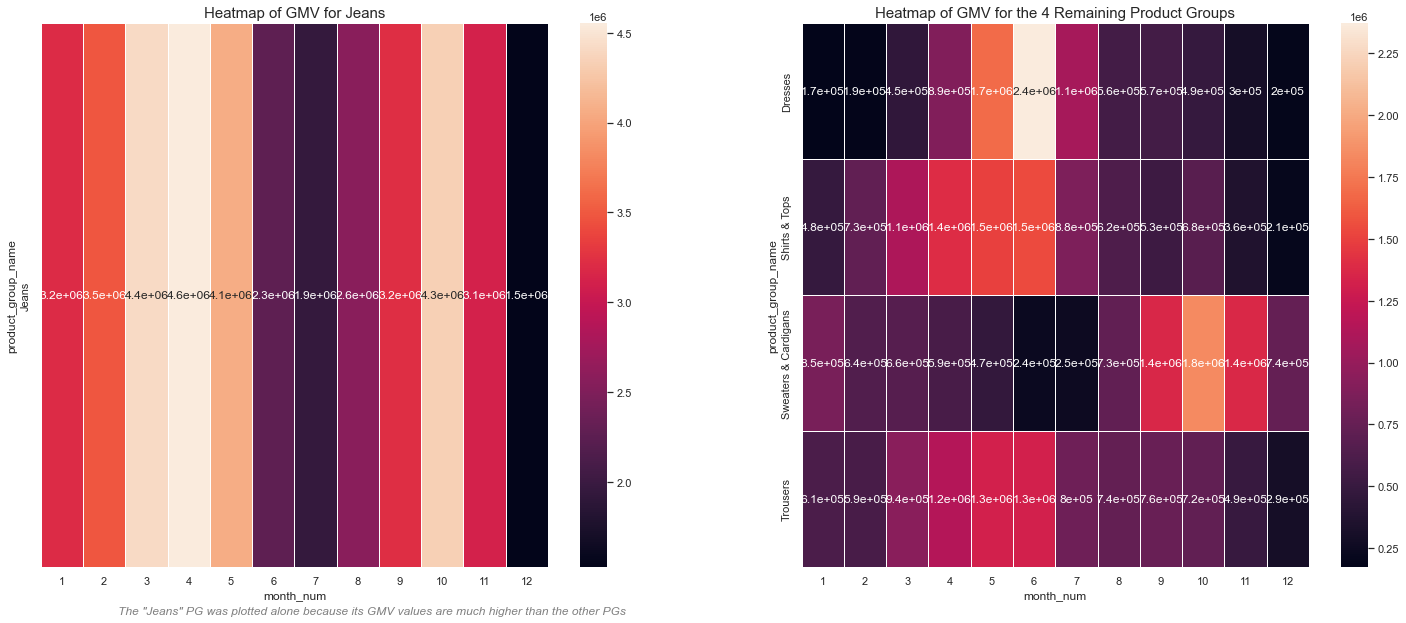

In [11]:
# Step 7.3: Plot a heat map of the GMV per month
## Drop the first day of the new year so that it does not get added to the data of Jan 2021
df_sales_and_inventory_top5_agg_month = df_sales_and_inventory_top5[df_sales_and_inventory_top5['dayofyear'] != 366] \
    .groupby(['month_num', 'month_str', 'product_group_name'], as_index = False)['items_sold', 'gmv', 'items_left_in_stock'] \
    .sum().sort_values(by = ['month_num', 'product_group_name'])

# Create a pivot table that can be fed to the sns.heatmap function
df_sales_and_inventory_top5_agg_month_pivot = df_sales_and_inventory_top5_agg_month.pivot_table(index = 'product_group_name', columns = ['month_num'], values = 'gmv')

# Create two data frames, one for Jeans alone and another one for the remaining 4 product groups
df_heatmap_indices = df_sales_and_inventory_top5_agg_month_pivot.index.get_level_values(level = 'product_group_name')
df_heatmap_jeans = df_sales_and_inventory_top5_agg_month_pivot[df_heatmap_indices == 'Jeans']
df_heatmap_others = df_sales_and_inventory_top5_agg_month_pivot[df_heatmap_indices != 'Jeans']

# Plot the heatmap
fig2, axes2 = plt.subplots(nrows = 1, ncols = 2, figsize = (25, 10))
sns.heatmap(ax = axes2[0], data = df_heatmap_jeans, linecolor = 'white', linewidths = 1, annot = True)
axes2[0].set_title('Heatmap of GMV for Jeans', fontdict = {'size': 15})
fig2.text(0.45, 0.06, 'The "Jeans" PG was plotted alone because its GMV values are much higher than the other PGs', ha = 'right', fontdict = {'color': 'gray', 'style': 'italic'})

sns.heatmap(ax = axes2[1], data = df_heatmap_others, linecolor = 'white', linewidths = 1, annot = True)
axes2[1].set_title('Heatmap of GMV for the 4 Remaining Product Groups', fontdict = {'size': 15})

Text(0.5, 1.0, 'A Time Series Plot of the Percentage of Products on Sale Per Product Group')

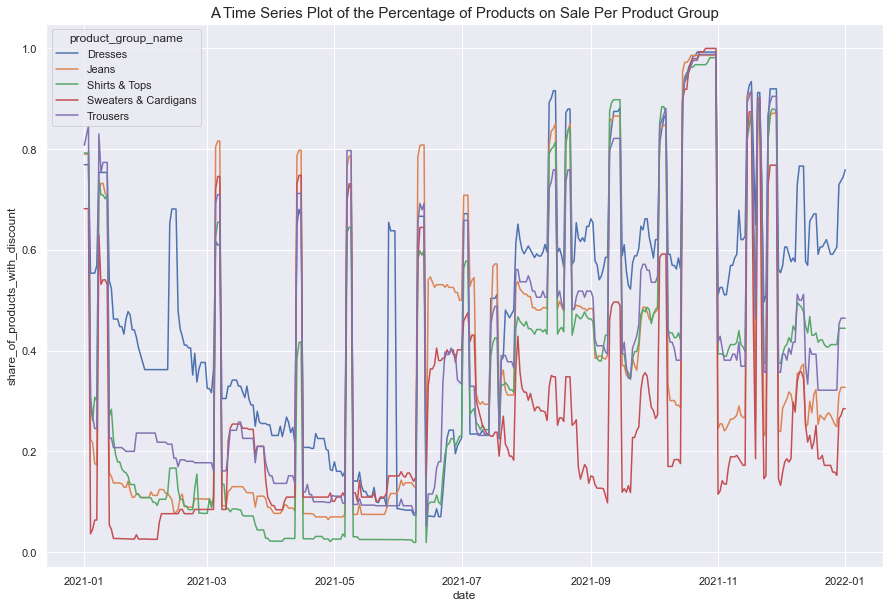

In [12]:
# Step 7.4: Plot the daily share of products on sale
df_promo_trends = df_sales_and_inventory_top5.groupby(['date', 'product_group_name'], as_index = False) \
    .agg(
        tot_products = ('product_id', lambda x: x.nunique()),
        tot_products_with_discount = ('discount', lambda x: x[x > 0].count())
    )
df_promo_trends['share_of_products_with_discount'] = round(df_promo_trends['tot_products_with_discount'] / df_promo_trends['tot_products'], 4)

plt.figure(figsize = (15,10))
sns.lineplot(x = 'date', y = 'share_of_products_with_discount', data = df_promo_trends, hue = 'product_group_name')
plt.title('A Time Series Plot of the Percentage of Products on Sale Per Product Group', fontdict = {'size': 15})

### Step 8: Analyze the Impact of Pricing Decisions on Sales

In [13]:
# Step 8.1: Calculate the correlation coefficients between "price_after_discount" and "items_sold" for every product_id

# Create a data frame containing the unique combinations of "product_id" and "product_group_name"
df_prod_ids_and_groups = df[['product_group_name', 'product_id']].drop_duplicates().sort_values(by = ['product_group_name', 'product_id']).reset_index(drop = True)

# Append a third column to this data frame. 
# This column will contain the correlation coefficient of each product_id. The correlation will be calculated between "price_after_discount" and "items_sold"
df_prod_ids_and_groups['corr_coeff'] = None 

# Create a function that computes the correlation coefficient for any "product_group" | "prod_id" combination
def corr_vals_func(df, prod_group, prod_id):
    df_temp = df[(df['product_id'] == prod_id) & (df['product_group_name'] == prod_group)]
    return df_temp[['price_after_discount', 'items_sold']].corr().values[0,1]

for i in range(len(df_prod_ids_and_groups)):
    df_prod_ids_and_groups.iloc[i,2] = corr_vals_func(df, df_prod_ids_and_groups.iloc[i, 0], df_prod_ids_and_groups.iloc[i, 1])

display(df_prod_ids_and_groups)

,product_group_name,product_id,corr_coeff
0,Ankle Boots,2508,-0.30786
1,Blazers,199,-0.224554
2,Blazers,2080,-0.224047
3,Blazers,3215,-0.090655
4,Blazers,3702,-0.483269
...,...,...,...
995,Trousers,10117,-0.166133
996,Trousers,10121,-0.371482
997,Trousers,10581,0.349029
998,Trousers,11401,0.402916


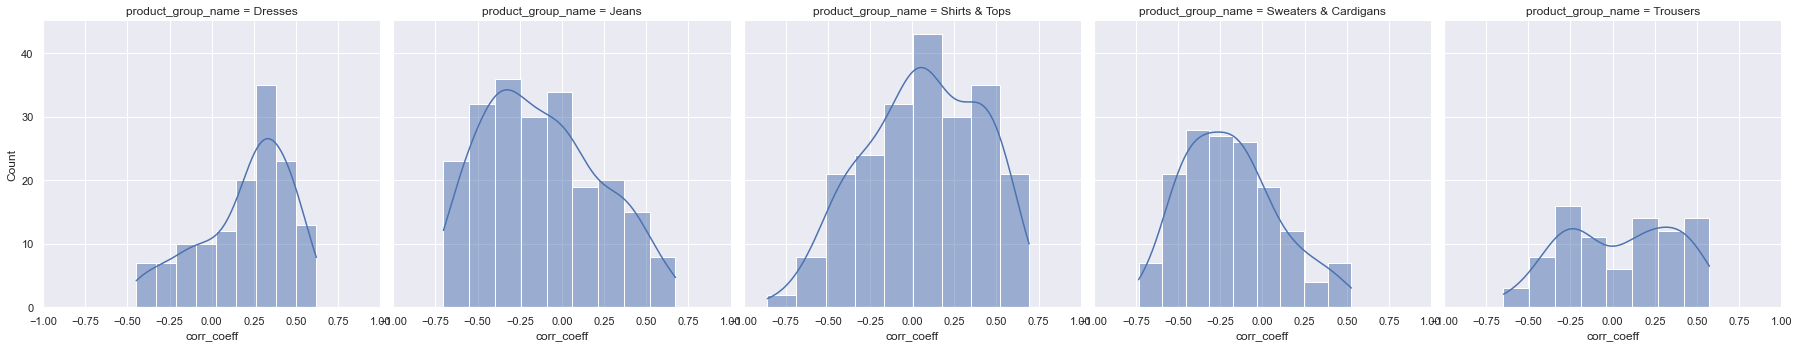

In [14]:
# Step 8.2: Plot the correlation coefficients obtained in the previous step
x = df_prod_ids_and_groups[df_prod_ids_and_groups['product_group_name'].isin(top5_prod_groups)]
g = sns.FacetGrid(data = x, col = 'product_group_name', height = 5, aspect = 1)
g.map(sns.histplot, 'corr_coeff', kde = True)
g.set(xlim = (-1, 1))

### Time Series Forecasting

In [15]:
# Make a copy of the original data frame
df_ts = df.copy()

# Add the date columns
df_ts['year'] = 2021
df_ts['combined'] = df_ts['year']*1000 + df_ts['dayofyear']
df_ts['date'] = pd.to_datetime(df_ts['combined'], format = '%Y%j')
df_ts['week_num'] = df_ts['date'].dt.isocalendar().week
df_ts['week'] = [truncate(i, 'week') for i in df_ts['date']]
df_ts['month_str'] = df_ts['date'].dt.strftime('%b')
df_ts['month_num'] = df_ts['date'].dt.month

# Select only the columns that are relevant for time series analysis
df_ts_trimmed = df_ts[['date', 'items_sold']].groupby('date').sum().sort_index()

# Display the DF
df_ts_trimmed.head(10)

,items_sold
date,
2021-01-01,8552
2021-01-02,11621
2021-01-03,16131
2021-01-04,5124
2021-01-05,5092
2021-01-06,4813
2021-01-07,5460
2021-01-08,8836
2021-01-09,9951


<AxesSubplot:xlabel='date'>

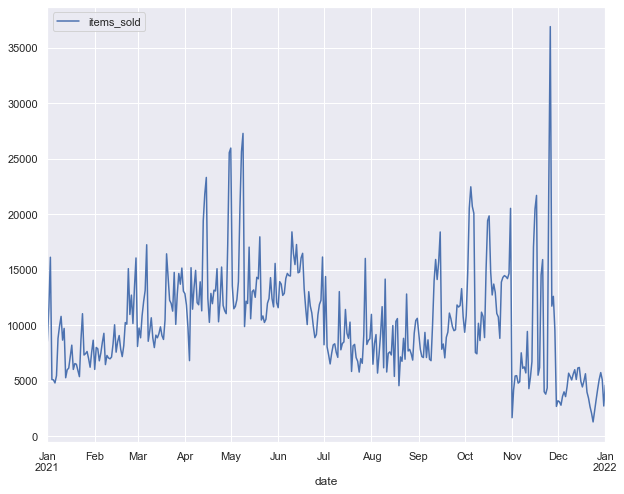

In [16]:
# Plot the daily sales
df_ts_trimmed.plot(figsize = (10,8))

In [17]:
# Test for stationarity
def adfuller_test_func(col):
    adfuller_test_result = adfuller(col)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value, label in zip(adfuller_test_result, labels):
        print(label + ' : ' + str(value) )
    if adfuller_test_result[1] <= 0.05:
        print("We reject the null hypothesis. Thus, the data is stationary")
    else:
        print("We accept the null hypothesis. Thus, the data is non-stationary ")

adfuller_test_func(df_ts_trimmed['items_sold'])

ADF Test Statistic : -2.731598356511432
p-value : 0.0687281548692344
#Lags Used : 8
Number of Observations Used : 357
We accept the null hypothesis. Thus, the data is non-stationary 


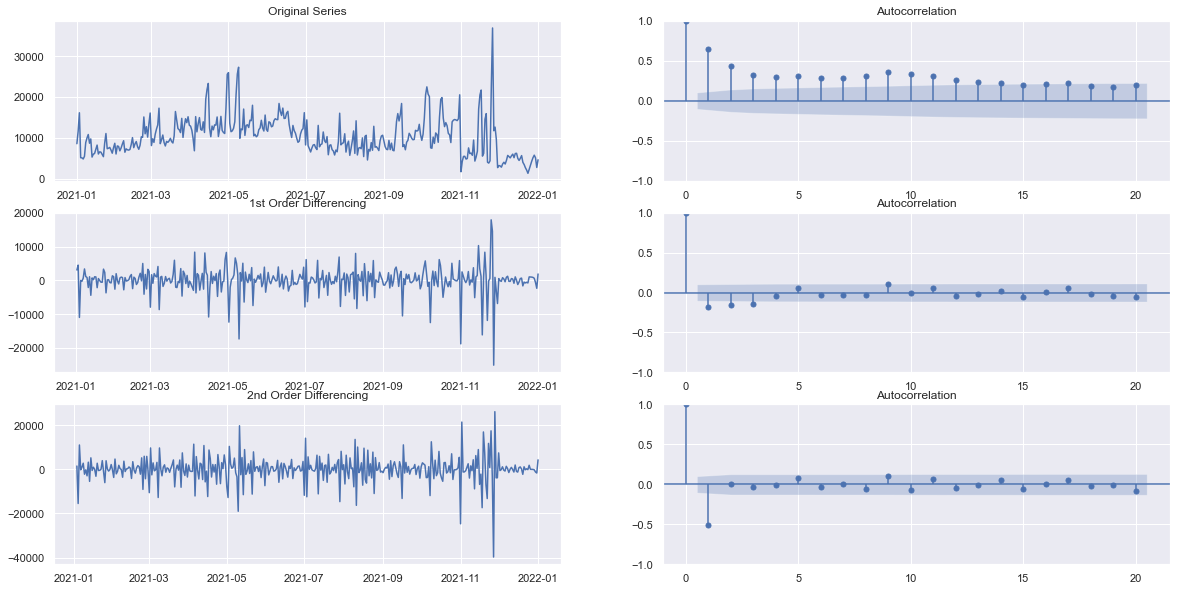

In [18]:
# Series is not stationary, so experiment with differencing

# Original Series
fig, axes = plt.subplots(3, 2, figsize = (20,10))
axes[0, 0].plot(df_ts_trimmed['items_sold'])
axes[0, 0].set_title('Original Series')
plot_acf(df_ts_trimmed['items_sold'], lags = 20, ax = axes[0, 1]);

# 1st Differencing
axes[1, 0].plot(df_ts_trimmed['items_sold'].diff())
axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_ts_trimmed['items_sold'].diff().dropna(), lags = 20, ax = axes[1, 1]);

# 2nd Differencing
axes[2, 0].plot(df_ts_trimmed['items_sold'].diff().diff())
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_ts_trimmed['items_sold'].diff().diff().dropna(), lags = 20, ax = axes[2, 1]);

In [19]:
# Differencing (try out the weekly first difference)
df_ts_trimmed['daily_first_diff'] = df_ts_trimmed['items_sold'] - df_ts_trimmed['items_sold'].shift(1)
df_ts_trimmed['daily_second_diff'] = df_ts_trimmed['items_sold'] - df_ts_trimmed['items_sold'].shift(2)
df_ts_trimmed.head(10)

,items_sold,daily_first_diff,daily_second_diff
date,,,
2021-01-01,8552,NaN,NaN
2021-01-02,11621,3069.0,NaN
2021-01-03,16131,4510.0,7579.0
2021-01-04,5124,-11007.0,-6497.0
2021-01-05,5092,-32.0,-11039.0
2021-01-06,4813,-279.0,-311.0
2021-01-07,5460,647.0,368.0
2021-01-08,8836,3376.0,4023.0
2021-01-09,9951,1115.0,4491.0


In [20]:
# Apply the adfuller test again to check if the data is stationary
adfuller_test_func(df_ts_trimmed['daily_first_diff'].dropna())
print('\n')
adfuller_test_func(df_ts_trimmed['daily_second_diff'].dropna())

ADF Test Statistic : -11.808212752509652
p-value : 8.989958495015012e-22
#Lags Used : 7
Number of Observations Used : 357
We reject the null hypothesis. Thus, the data is stationary


ADF Test Statistic : -7.415931832026085
p-value : 6.93574288097006e-11
#Lags Used : 13
Number of Observations Used : 350
We reject the null hypothesis. Thus, the data is stationary


<AxesSubplot:xlabel='date'>

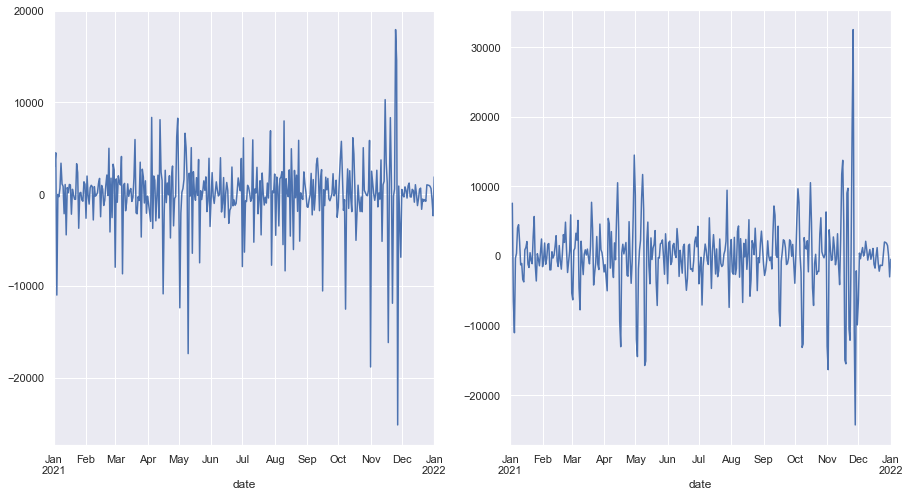

In [21]:
# Plot the daily_first_diff column
fig, ax = plt.subplots(1, 2, figsize = (15, 8))

df_ts_trimmed['daily_first_diff'].plot(ax = ax[0])

df_ts_trimmed['daily_second_diff'].plot(ax = ax[1])

j:\My Drive\AUC Drive\Entrepreneurial Path and Financial Freedom\Freelancing\about_you_case\venv_about_you_case\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Text(0.5, 1.0, 'Partial Autocorrelation - Daily Second Diff')

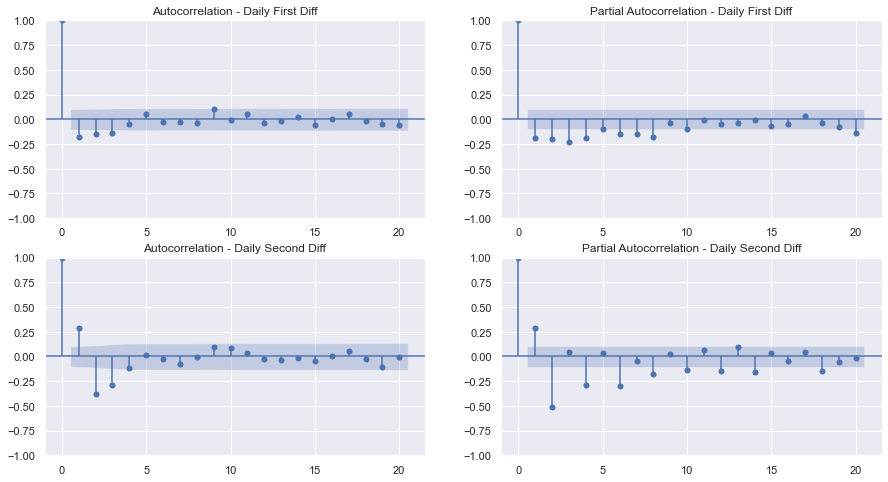

In [26]:
# Plot the ACF and PACF graphs
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(2,2,1)
fig = plot_acf(df_ts_trimmed['daily_first_diff'].dropna(), lags = 20, ax = ax1) # To find MA (q)
ax1.set_title('Autocorrelation - Daily First Diff')

ax2 = fig.add_subplot(2,2,2)
fig = plot_pacf(df_ts_trimmed['daily_first_diff'].dropna(), lags = 20, ax = ax2) # To find AR (p)
ax2.set_title('Partial Autocorrelation - Daily First Diff')

ax3 = fig.add_subplot(2,2,3)
fig = plot_acf(df_ts_trimmed['daily_second_diff'].dropna(), lags = 20, ax = ax3) # To find MA (q)
ax3.set_title('Autocorrelation - Daily Second Diff')

ax4 = fig.add_subplot(2,2,4)
fig = plot_pacf(df_ts_trimmed['daily_second_diff'].dropna(), lags = 20, ax = ax4) # To find AR (p)
ax4.set_title('Partial Autocorrelation - Daily Second Diff')

# Seems like a good value for p is 1 and for q is 1

In [23]:
# Implement the ARIMA model with p = 3, d = 1, and q = 3
arima_model = ARIMA(df_ts_trimmed['items_sold'], order = (1,1,1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

j:\My Drive\AUC Drive\Entrepreneurial Path and Financial Freedom\Freelancing\about_you_case\venv_about_you_case\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
j:\My Drive\AUC Drive\Entrepreneurial Path and Financial Freedom\Freelancing\about_you_case\venv_about_you_case\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
j:\My Drive\AUC Drive\Entrepreneurial Path and Financial Freedom\Freelancing\about_you_case\venv_about_you_case\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
j:\My Drive\AUC Drive\Entrepreneurial Path and Financial Freedom\Freelancing\about_you_case\venv_about_you_case\lib\site-pac

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             items_sold   No. Observations:                  366
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3494.944
Date:                Thu, 21 Jul 2022   AIC                           6995.888
Time:                        15:37:28   BIC                           7007.587
Sample:                    01-01-2021   HQIC                          7000.537
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4860      0.037     13.175      0.000       0.414       0.558
ma.L1         -0.9287      0.027    -34.296      0.000      -0.982      -0.876
sigma2      1.321e+07   1.11e-09   1.19e+16      0.000    1.32e+07    1.32e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.68   Jarque-Bera (JB):               515.69
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               2.39   Skew:                             0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.74e+30. Standard errors may be unstable.
"""

Text(0.5, 1.0, 'ARIMA Model - Actual vs. Forecasted Values')

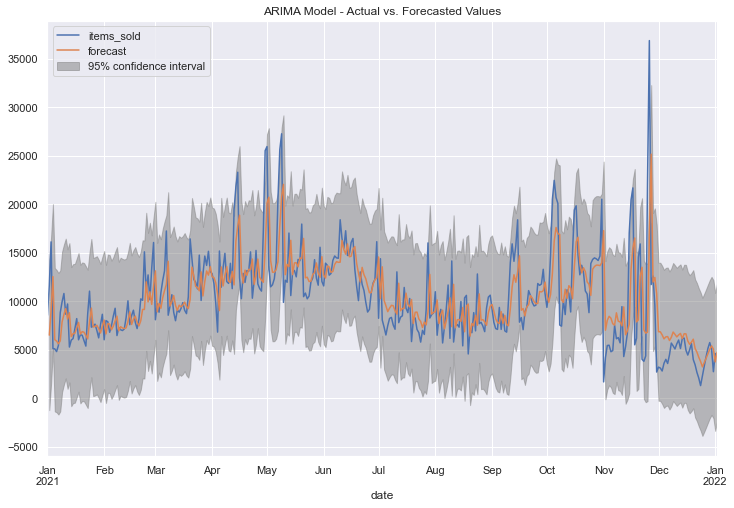

In [24]:
# Plot the values vs. the forecast
fig = plt.figure(figsize = (10,8))
ax_pred = fig.add_subplot(1,1,1)

df_ts_trimmed['items_sold_forecast'] = arima_model_fit.predict(start=1, end=366)
df_ts_trimmed[['items_sold']].plot(figsize=(12,8), ax = ax_pred)

plot_predict(arima_model_fit, 1, 366, ax = ax_pred);
plt.title('ARIMA Model - Actual vs. Forecasted Values')

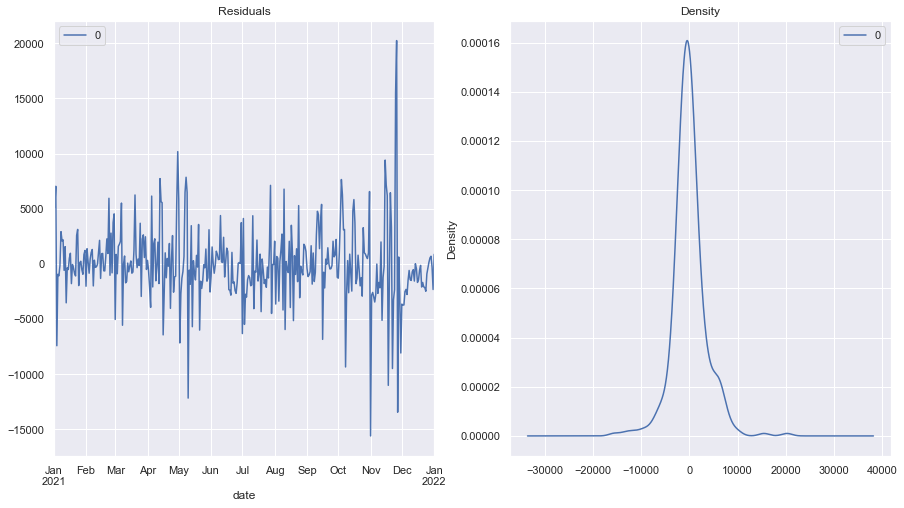

In [25]:
residuals = pd.DataFrame(arima_model_fit.resid)
fig, ax = plt.subplots(1,2, figsize = (15,8))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()